In [1]:
import itertools
# 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_ta as ta
import yfinance as yf
# 
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

In [2]:
# parameters
num_class = 5
split_date = '2023-04-01'
random_state=42
start_date = '2007-01-01'
end_date = '2024-05-01'

In [3]:
# daily data download
df = pd.read_csv('NDX_Daily_200808060000_202405100000.csv',delimiter='\t')
# df = pd.read_csv('NDX_Daily_201501020000_202405100000.csv',delimiter='\t')
df.drop(columns=['<VOL>','<TICKVOL>','<SPREAD>'], inplace=True)
df.rename(columns={'<DATE>':'Date',
                   '<OPEN>':'Open',
                   '<HIGH>':'High',
                   '<LOW>':'Low',
                   '<CLOSE>':'Close',
                   },inplace=True)
df['Date'] = pd.to_datetime(df['Date'], format='%Y.%m.%d')
df.sort_values(by=['Date'],inplace=True)
df

,Date,Open,High,Low,Close
0,2008-08-06,1867.0,1903.0,1853.0,1895.0
1,2008-08-07,1881.0,1904.0,1873.0,1880.0
2,2008-08-08,1879.0,1929.0,1877.0,1926.0
3,2008-08-11,1922.0,1963.0,1918.0,1941.0
4,2008-08-12,1938.0,1957.0,1932.0,1941.0
...,...,...,...,...,...
4225,2024-05-06,17923.1,18106.5,17888.8,18090.4
4226,2024-05-07,18090.4,18169.6,18056.8,18101.4
4227,2024-05-08,18101.9,18150.1,17980.1,18069.5
4228,2024-05-09,18068.2,18148.1,18013.0,18128.7


In [4]:
# Feature Engineering (on Returns, not on Price)
# returns for Features (no look-ahead bias):
df['Rp'] = df['Close'].pct_change()
# 
ema_14_rp = df.ta.ema(length=14, close='Rp')
rsi_14_rp = df.ta.rsi(length=14, close='Rp')
emsd_rp = df['Rp'] - ema_14_rp
# Assign the resulting columns to the DataFrame with desired names
df['Rp_ema_14'] = ema_14_rp
df['Rp_rsi_14'] = rsi_14_rp
df['EMSD_Rp'] = emsd_rp
# target
df['Rp'] = df['Close'].pct_change().shift(-1)
# 
df

,Date,Open,High,Low,Close,Rp,Rp_ema_14,Rp_rsi_14,EMSD_Rp
0,2008-08-06,1867.0,1903.0,1853.0,1895.0,-0.007916,NaN,NaN,NaN
1,2008-08-07,1881.0,1904.0,1873.0,1880.0,0.024468,NaN,NaN,NaN
2,2008-08-08,1879.0,1929.0,1877.0,1926.0,0.007788,NaN,NaN,NaN
3,2008-08-11,1922.0,1963.0,1918.0,1941.0,0.000000,NaN,NaN,NaN
4,2008-08-12,1938.0,1957.0,1932.0,1941.0,0.000515,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
4225,2024-05-06,17923.1,18106.5,17888.8,18090.4,0.000608,0.003399,52.179504,0.006127
4226,2024-05-07,18090.4,18169.6,18056.8,18101.4,-0.001762,0.003027,49.768912,-0.002419
4227,2024-05-08,18101.9,18150.1,17980.1,18069.5,0.003276,0.002388,49.119355,-0.004150
4228,2024-05-09,18068.2,18148.1,18013.0,18128.7,0.001186,0.002507,50.595410,0.000770


In [5]:
# training quantiles training
features = ['Rp_ema_14','Rp_rsi_14','EMSD_Rp']
target = 'Rp'
df.dropna(inplace=True)
train_df = df.loc[df.Date < split_date]
test_df = df.loc[df.Date >= split_date]
X_train = train_df[features].values
y_train = train_df[target].values
X_test = test_df[features].values
y_test = test_df[target].values
# scaling
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
y_train_quantiles = pd.qcut(y_train, q=num_class, labels=False)

In [6]:
# class prediction
xgb_classifier = XGBClassifier(objective='multi:softmax', num_class=num_class, random_state=random_state)
xgb_classifier.fit(X_train_scaled, y_train_quantiles)
# Predict classes for the test sample
y_train_test = xgb_classifier.predict(X_train_scaled)
y_pred_test = xgb_classifier.predict(X_test_scaled)
y_pred_all = np.concatenate((y_train_test, y_pred_test))
df['Predicted_Class'] = y_pred_all
df

,Date,Open,High,Low,Close,Rp,Rp_ema_14,Rp_rsi_14,EMSD_Rp,Predicted_Class
15,2008-08-27,1887.0,1914.0,1882.0,1900.0,0.007895,0.000644,54.464174,0.006779,3
16,2008-08-28,1907.0,1921.0,1904.0,1915.0,-0.021932,0.001611,54.647923,0.006284,0
17,2008-08-29,1898.0,1900.0,1867.0,1873.0,-0.012280,-0.001528,42.866650,-0.020404,0
18,2008-09-02,1905.0,1913.0,1843.0,1850.0,-0.009189,-0.002962,46.859256,-0.009318,1
19,2008-09-03,1849.0,1854.0,1820.0,1833.0,-0.031642,-0.003792,48.109643,-0.005397,0
...,...,...,...,...,...,...,...,...,...,...
4224,2024-05-03,17638.6,17942.4,17617.5,17919.7,0.009526,0.002456,53.939153,0.013538,3
4225,2024-05-06,17923.1,18106.5,17888.8,18090.4,0.000608,0.003399,52.179504,0.006127,2
4226,2024-05-07,18090.4,18169.6,18056.8,18101.4,-0.001762,0.003027,49.768912,-0.002419,2
4227,2024-05-08,18101.9,18150.1,17980.1,18069.5,0.003276,0.002388,49.119355,-0.004150,2


In [7]:
# returns profile
conditions = [df['Predicted_Class'].isin([0,1,2,3,4]) # long
              , df['Predicted_Class'].isin([0,1,2,3,4]) # short
              ]
signals = [1
           , -1]
# Create the "signal" column using np.select
df['signal'] = np.select(conditions, signals, default=0)
df['returns'] = df['signal']*df['Rp']
# Returns IS
df['cum_returns'] = (df['returns'] + 1).cumprod()
# sharpe ratios
std_dev = df['returns'].std()*np.sqrt(252)
ar = df['returns'].cumsum().iloc[-1]/((len(df)+1)/365.2)
sharpe_ratio = ar / std_dev
print("sharpe_ratio IS:",sharpe_ratio)
# Returns OOS
test_df = df.loc[df.Date >= split_date].copy()
test_df['cum_returns'] = (test_df['returns'] + 1).cumprod()
# sharpe ratios
std_dev = test_df['returns'].std()*np.sqrt(252)
ar = test_df['returns'].cumsum().iloc[-1]/((len(test_df)+1)/365.2)
sharpe_ratio = ar / std_dev
print("sharpe_ratio OOS:",sharpe_ratio)

sharpe_ratio IS: 1.0477245257461323
sharpe_ratio OOS: 2.655826180515762


In [8]:
all_classes = list(range(num_class))
# Initialize a DataFrame to store the Sharpe ratios for each combination
sharpe_ratios_df = []
# Generate all possible combinations of long and short classes
for subset_length in range(num_class + 1):
    for long_classes in itertools.combinations(all_classes, r=subset_length):
        print(long_classes)
        short_classes = [item for item in all_classes if item not in long_classes]
        # Filter data based on the long and short classes
        long_condition = df['Predicted_Class'].isin(long_classes)
        short_condition = df['Predicted_Class'].isin(short_classes)
        df['signal'] = np.select([long_condition, short_condition], [1, -1], default=0)
        # Calculate returns
        df['returns'] = df['signal'] * df['Rp']
        # Calculate cumulative returns
        df['cum_returns'] = (df['returns'] + 1).cumprod()
        # Calculate Sharpe ratio for in-sample data
        std_dev_is = df['returns'].std() * np.sqrt(252)
        ar_is = df['returns'].cumsum().iloc[-1] / ((len(df) + 1) / 365.2)
        sharpe_ratio_is = ar_is / std_dev_is
        # Filter test data based on split_date
        test_df = df.loc[df.Date >= split_date].copy()
        # Calculate Sharpe ratio for out-of-sample data
        std_dev_oos = test_df['returns'].std() * np.sqrt(252)
        ar_oos = test_df['returns'].cumsum().iloc[-1] / ((len(test_df) + 1) / 365.2)
        sharpe_ratio_oos = ar_oos / std_dev_oos
        # Append the Sharpe ratios to the DataFrame
        sharpe_ratios_df.append({'Long_Classes': long_classes,
                                                    'Short_Classes': short_classes,
                                                    'Sharpe_Ratio_IS': sharpe_ratio_is,
                                                    'Sharpe_Ratio_OOS': sharpe_ratio_oos
                                                    })
sharpe_ratios_df = pd.DataFrame(sharpe_ratios_df)

()
(0,)
(1,)
(2,)
(3,)
(4,)
(0, 1)
(0, 2)
(0, 3)
(0, 4)
(1, 2)
(1, 3)
(1, 4)
(2, 3)
(2, 4)
(3, 4)
(0, 1, 2)
(0, 1, 3)
(0, 1, 4)
(0, 2, 3)
(0, 2, 4)
(0, 3, 4)
(1, 2, 3)
(1, 2, 4)
(1, 3, 4)
(2, 3, 4)
(0, 1, 2, 3)
(0, 1, 2, 4)
(0, 1, 3, 4)
(0, 2, 3, 4)
(1, 2, 3, 4)
(0, 1, 2, 3, 4)


In [9]:
sharpe_ratios_df.sort_values(by=['Sharpe_Ratio_IS'], ascending=[False],inplace=True)
sharpe_ratios_df

,Long_Classes,Short_Classes,Sharpe_Ratio_IS,Sharpe_Ratio_OOS
25,"(2, 3, 4)","[0, 1]",14.737999,-1.083393
15,"(3, 4)","[0, 1, 2]",13.812146,-0.144100
30,"(1, 2, 3, 4)",[0],12.268395,0.478943
24,"(1, 3, 4)","[0, 2]",11.459363,1.419646
14,"(2, 4)","[0, 1, 3]",10.548769,-1.579827
5,"(4,)","[0, 1, 2, 3]",9.806138,-0.638240
23,"(1, 2, 4)","[0, 3]",8.537878,-0.015056
12,"(1, 4)","[0, 2, 3]",7.858363,0.923779
29,"(0, 2, 3, 4)",[1],2.648145,1.078296
13,"(2, 3)","[0, 1, 4]",2.353822,-3.110653


In [10]:
sharpe_ratios_df.sort_values(by=['Sharpe_Ratio_OOS'], ascending=[False],inplace=True)
sharpe_ratios_df

,Long_Classes,Short_Classes,Sharpe_Ratio_IS,Sharpe_Ratio_OOS
28,"(0, 1, 3, 4)",[2],0.478873,3.620686
18,"(0, 1, 4)","[2, 3]",-2.353822,3.110653
31,"(0, 1, 2, 3, 4)",[],1.047725,2.655826
27,"(0, 1, 2, 4)",[3],-1.779018,2.153701
21,"(0, 3, 4)","[1, 2]",2.071241,2.023044
17,"(0, 1, 3)","[2, 4]",-10.548769,1.579827
9,"(0, 4)","[1, 2, 3]",-0.757878,1.524663
24,"(1, 3, 4)","[0, 2]",11.459363,1.419646
6,"(0, 1)","[2, 3, 4]",-14.737999,1.083393
29,"(0, 2, 3, 4)",[1],2.648145,1.078296


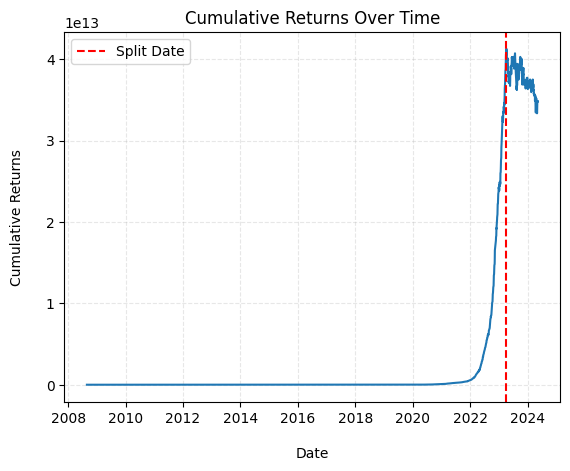

In [11]:
long_classes = [2,3,4]
short_classes = [item for item in all_classes if item not in long_classes]
# Filter data based on the long and short classes
long_condition = df['Predicted_Class'].isin(long_classes)
short_condition = df['Predicted_Class'].isin(short_classes)
df['signal'] = np.select([long_condition, short_condition], [1, -1], default=0)
# Calculate returns
df['returns'] = df['signal'] * df['Rp']
# Calculate cumulative returns
df['cum_returns'] = (df['returns'] + 1).cumprod()

# Plot the cumulative results
plt.plot(df['Date'],df['cum_returns'])
plt.xlabel('\nDate')
# plt.xticks(df['Date'], rotation=90)
plt.ylabel('Cumulative Returns\n')
plt.title('Cumulative Returns Over Time')
plt.grid(True,alpha=0.3,linestyle='--')
split_date = pd.to_datetime(split_date)
plt.axvline(x=split_date, color='r', linestyle='--', label='Split Date')
plt.legend()
plt.show()